# Model Training & Evaluation

### Read data

In [323]:
import scipy.sparse as sp
import numpy as np

X_train_count = sp.load_npz('./features/train_count.npz')
X_test_count = sp.load_npz('./features/test_count.npz')

X_train_tfidf = sp.load_npz('./features/train_tfidf.npz')
X_test_tfidf = sp.load_npz('./features/test_tfidf.npz')

X_train_tfidf_bigram = sp.load_npz('./features/train_tfidf_bigram.npz')
X_test_tfidf_bigram = sp.load_npz('./features/test_tfidf_bigram.npz')

y_train = np.load('./features/y_train.npy')
y_test = np.load('./features/y_test.npy')

z_train = np.load('./features/z_train.npy')
z_test = np.load('./features/z_test.npy')

In [324]:
y_train = y_train.ravel()
z_train = z_train.ravel()

In [381]:
tc = 0
fc = 0
for z in z_train:
    if z == True:
        tc += 1
    else:
        fc += 1
        
print(tc, fc)

341 3159


### Dummy Baseline

In [327]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_count, z_train)
dummy_y_pred = dummy_clf.predict(X_test_count)
print(classification_report(z_test, dummy_y_pred))

              precision    recall  f1-score   support

       False       0.90      1.00      0.95      1344
        True       0.00      0.00      0.00       156

    accuracy                           0.90      1500
   macro avg       0.45      0.50      0.47      1500
weighted avg       0.80      0.90      0.85      1500



### Logistic Regression

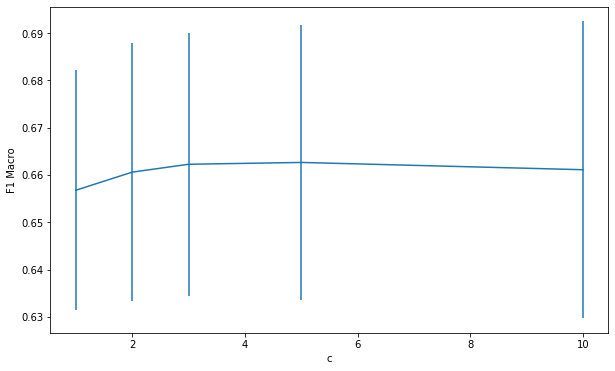

In [388]:
import matplotlib.pyplot as plt

# C = [0.0001, 0.001, 0.01, 0.1, 1]
C = [1, 2, 3, 5, 10]
accuracy = []
std = []

for c in C:
    model = LogisticRegression(max_iter=250, C = c)
    scores = cross_val_score(model, X_train_tfidf, z_train, cv=5, scoring='roc_auc')
    accuracy.append(scores.mean())
    std.append(scores.std())
    
plt.errorbar(C, accuracy, yerr=std)
plt.xlabel('c')
plt.ylabel('F1 Macro')
plt.gcf().set_size_inches(10, 6)
plt.show()

In [378]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr_clf = LogisticRegression(max_iter=250, C=100)
lr_clf.fit(X_train_tfidf, z_train)
lr_y_pred = lr_clf.predict(X_test_tfidf)
print(classification_report(z_test, lr_y_pred))

              precision    recall  f1-score   support

       False       0.90      0.95      0.92      1344
        True       0.14      0.07      0.09       156

    accuracy                           0.86      1500
   macro avg       0.52      0.51      0.51      1500
weighted avg       0.82      0.86      0.84      1500



In [401]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=50, metric='hamming')
knn.fit(X_train_count.toarray(), z_train)
knn_y_pred = knn.predict(X_test_count.toarray())
print(classification_report(z_test, knn_y_pred))

              precision    recall  f1-score   support

       False       0.90      1.00      0.95      1344
        True       0.00      0.00      0.00       156

    accuracy                           0.90      1500
   macro avg       0.45      0.50      0.47      1500
weighted avg       0.80      0.90      0.85      1500



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Support Vector Machine
- Using Gaussian kernel to find potentially non-linear decision boundary

**Hyperparameters**
- Grid search $C \in [0.1, 1, 100, 1000]$ and $\gamma \in [0.001, 0.1, 1, 3]$

**Findings**
- Best params were $C = 1$ and $\gamma = 1$
- These parameters give roughly the same accuracy as LR, but slower.
- This similarity in performance indicates that the data is linearly separable

In [354]:
from sklearn.model_selection import GridSearchCV

parameter_space = {
    'C': [0.1, 1, 100, 1000],
    'gamma': [0.001, 0.1, 1, 3]
}

gsc = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=parameter_space, cv=5, scoring='accuracy')
grid_result = gsc.fit(X_train_tfidf, z_train)
best_params = grid_result.best_params_
best_params

{'C': 0.1, 'gamma': 0.001}

In [361]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='rbf', C=1000, gamma=0.001)
svm_clf.fit(X_train_tfidf_bigram, z_train)
svm_y_pred = svm_clf.predict(X_test_tfidf_bigram)
print(classification_report(z_test, svm_y_pred))

              precision    recall  f1-score   support

       False       0.90      0.99      0.94      1344
        True       0.27      0.04      0.07       156

    accuracy                           0.89      1500
   macro avg       0.59      0.51      0.50      1500
weighted avg       0.83      0.89      0.85      1500



### Deep Neural Network

In [368]:
%%time
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

mlp_clf = MLPClassifier(max_iter=300)

parameter_space = {
    'hidden_layer_sizes': [(50, 30, 20), (50, 30, 20, 10), (30, 30, 20, 10, 10)],
    'alpha': [0.1, 0.0001],
}

grid_search = GridSearchCV(mlp_clf, parameter_space, cv=5, scoring='accuracy')
grid_search.fit(X_train_count, z_train)
mlp_best_params = grid_search.best_params_
print(f'Best params: {mlp_best_params}')

Best params: {'alpha': 0.0001, 'hidden_layer_sizes': (50, 30, 20)}
CPU times: user 7min 8s, sys: 12.5 s, total: 7min 20s
Wall time: 5min 15s


In [371]:
from sklearn.metrics import classification_report
mlp_clf = MLPClassifier(max_iter=300, hidden_layer_sizes=(50, 30, 20), alpha=0.0001)
mlp_clf.fit(X_train_count, z_train)
y_pred = mlp_clf.predict(X_test_count)
print(classification_report(z_test, y_pred))

              precision    recall  f1-score   support

       False       0.90      0.94      0.92      1344
        True       0.14      0.08      0.10       156

    accuracy                           0.85      1500
   macro avg       0.52      0.51      0.51      1500
weighted avg       0.82      0.85      0.83      1500



In [12]:
y_pred = mlp_clf.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.95      0.97      1736
        True       0.96      0.98      0.97      1764

    accuracy                           0.97      3500
   macro avg       0.97      0.97      0.97      3500
weighted avg       0.97      0.97      0.97      3500



In [13]:
from sklearn.model_selection import cross_val_score

mlp_clf = MLPClassifier(max_iter=300, hidden_layer_sizes=(50, 30, 20, 10), alpha=0.1)
scores = cross_val_score(mlp_clf, X_train, y_train, cv=5)
print('Mean acc.:', scores.mean())

Mean acc.: 0.7259999999999999


### ROC Curve & AUC

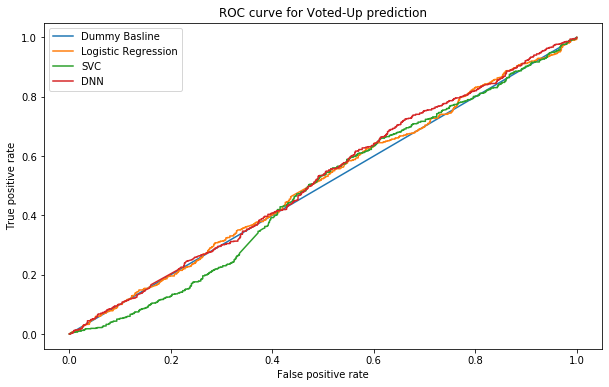

AUC Scores:
Dummy: 0.5
LR: 0.5101001210841027
SVM: 0.4880738790033056
DNN: 0.5179465843081403


In [389]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Dummy
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_tfidf, z_train)
dummy_z_pred_proba = dummy_clf.predict_proba(X_test_tfidf)[:, 1]

# Best Logistic Regression Model
lr_clf = LogisticRegression(max_iter=250, C=5)
lr_clf.fit(X_train_tfidf, z_train)
lr_z_pred_proba = lr_clf.predict_proba(X_test_tfidf)[:, 1]

# Best SVM Model
svm_clf = SVC(kernel='rbf', C=1000, gamma=0.001)
svm_clf.fit(X_train_tfidf, z_train)

# Best MLP
mlp_clf = MLPClassifier(max_iter=300, hidden_layer_sizes=(30, 30, 20, 10, 10), alpha=0.0001)
mlp_clf.fit(X_train_tfidf, z_train)
mlp_z_pred_proba = mlp_clf.predict_proba(X_test_tfidf)[:, 1]

# Calculate True/False positive rates
fpr_dummy, tpr_dummy, _ = roc_curve(y_test, dummy_z_pred_proba)
fpr_lr, tpr_lr, _ = roc_curve(y_test_bi, lr_z_pred_proba)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_clf.decision_function(X_test_tfidf))
fpr_mlp, tpr_mlp, _ = roc_curve(y_test_bi, mlp_z_pred_proba)

plt.plot(fpr_dummy, tpr_dummy)
plt.plot(fpr_lr, tpr_lr)
plt.plot(fpr_svm, tpr_svm)
plt.plot(fpr_mlp, tpr_mlp)
plt.gcf().set_size_inches(10, 6)
plt.title('ROC curve for Voted-Up prediction')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(('Dummy Basline', 'Logistic Regression', 'SVC', 'DNN'))
plt.show()

print('AUC Scores:')
print(f'Dummy: {auc(fpr_dummy, tpr_dummy)}')
print(f'LR: {auc(fpr_lr, tpr_lr)}')
print(f'SVM: {auc(fpr_svm, tpr_svm)}')
print(f'DNN: {auc(fpr_mlp, tpr_mlp)}')

### Learning Curves
- Large gaps between training and cross-validation accuracy indicate that in each case the models are overfitting the training data and failing to generalise well. Providing more training data could be one way to combat this issue, and considering the linear relationship between fit time and accuracy provided by the logistic regression model, this is certainly an option worth pursuing.

In [234]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Accuracy")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("Fit time (s)")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("Fit times (s)")
    axes[2].set_ylabel("Accuracy")
    axes[2].set_title("Performance of the model")

    return plt

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

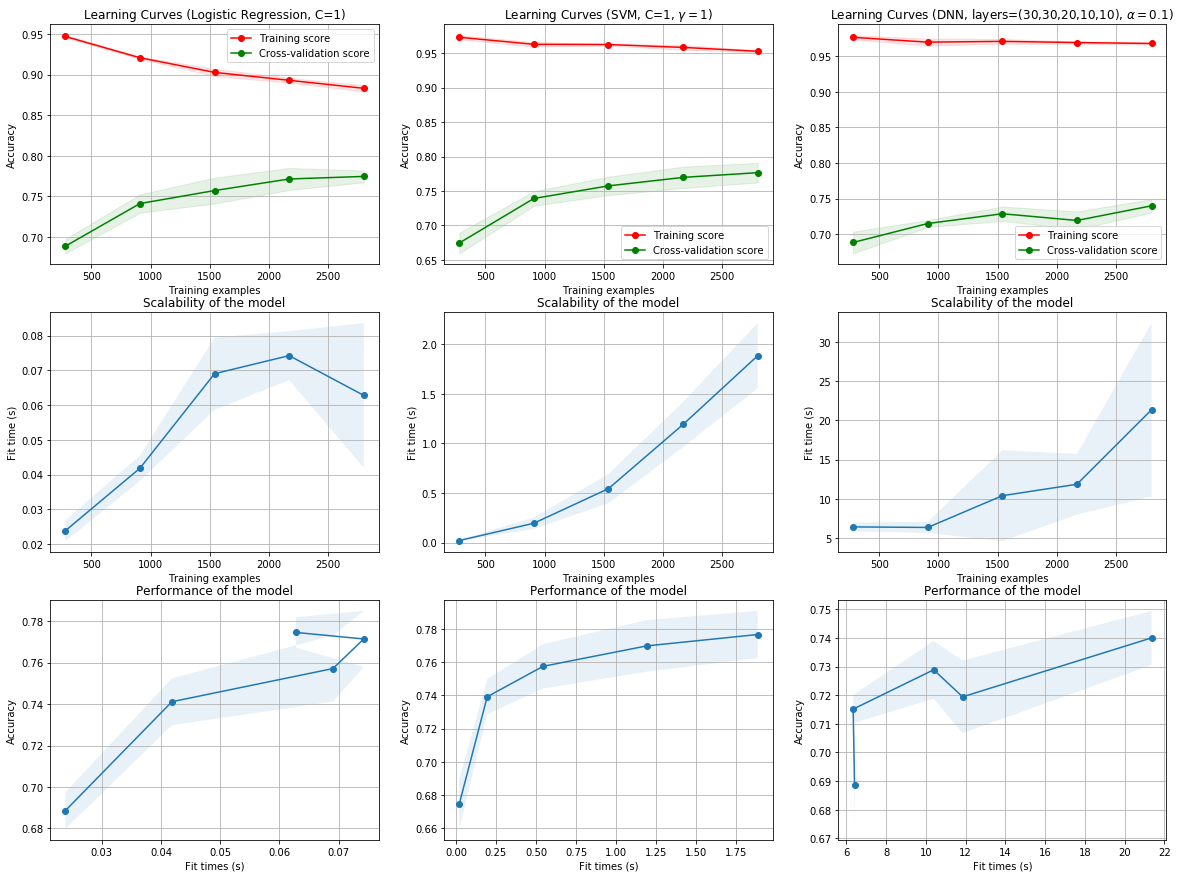

In [322]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

lr_clf = LogisticRegression(max_iter=250, C=1)
title = r"Learning Curves (Logistic Regression, C=1)"
plot_learning_curve(lr_clf, title, X_train_tfidf, y_train, axes=axes[:, 0],
                    cv=5, n_jobs=4)

svm_clf = SVC(kernel='rbf', C=1, gamma=1)
title = r"Learning Curves (SVM, C=1, $\gamma=1$)"
plot_learning_curve(svm_clf, title, X_train_tfidf_bigram, y_train, axes=axes[:, 1],
                    cv=5, n_jobs=4)

mlp_clf = MLPClassifier(max_iter=300, hidden_layer_sizes=(30, 30, 20, 10, 10), alpha=0.1)
title = r"Learning Curves (DNN, layers=(30,30,20,10,10), $\alpha=0.1$)"
plot_learning_curve(mlp_clf, title, X_train_count, y_train, axes=axes[:, 2],
                    cv=5, n_jobs=4)